# Python setup

In [1]:
import os

# Changes the notebook working directory on level up.
%cd ..

# Running main python script.
%run -i "src/main.py"

# Data set from main.py
data_set

c:\Users\aleks\Documents\Utdanning\UiS\DataScience\project\dat540-netflix_catalogue


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unknown director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unknown director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,Unknown director,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,Unknown date_added,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,Unknown director,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,Unknown date_added,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,Unknown director,Unknown cast,Unknown country,Unknown date_added,2016,Unknown rating,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,Unknown director,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown date_added,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


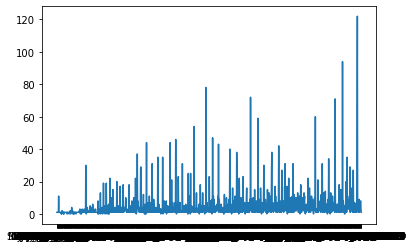

In [2]:
import datetime
from matplotlib import pyplot as plt 

# all unique dates 
date_added = list(set(data_set['date_added']))

datetime_list = []

for date in date_added:
    # remove ',' and leading whitespace from the date string
    sanitized_date_string = date.replace(',', '').lstrip()
    # discard unknown date
    if ('Unknown' not in sanitized_date_string):
        # convert to datetime object
        datetime_format = datetime.datetime.strptime(sanitized_date_string, '%B %d %Y')
        datetime_list.append(datetime_format)

# sort the unique dates
sorted_datetime = sorted(datetime_list)
sorted_datetime_string_list = []
# note that the datetime format is given in the format '%B %#d, %Y', the pound sign is needed 
# in order to remove leading zeroes in dates, '#' for windows '-' for linux (should the code not run)
for datetime_object in sorted_datetime:
    date_string = datetime_object.strftime('%B %#d, %Y')
    sorted_datetime_string_list.append(date_string)
    
# TODO: visualize the categories when they were added (look for themes relating to that period)
# TODO: visualize the frequency of categories added by dates (peak dates)

date_freq_dict = dict()
for date in sorted_datetime_string_list:
    date_freq_dict[date] = len(data_set.loc[data_set['date_added'] == date])

# Showing number of added assets for each unique date.
plt.plot(date_freq_dict.keys(), date_freq_dict.values())
plt.show()
    



In [3]:
date_freq_dict.keys()

2016', 'March 9, 2016', 'March 11, 2016', 'March 16, 2016', 'March 18, 2016', 'March 19, 2016', 'March 25, 2016', 'March 31, 2016', 'April 1, 2016', 'April 5, 2016', 'April 8, 2016', 'April 9, 2016', 'April 15, 2016', 'April 17, 2016', 'April 20, 2016', 'April 22, 2016', 'April 25, 2016', 'April 28, 2016', 'April 29, 2016', 'May 1, 2016', 'May 5, 2016', 'May 6, 2016', 'May 8, 2016', 'May 15, 2016', 'May 22, 2016', 'May 23, 2016', 'May 26, 2016', 'May 27, 2016', 'May 28, 2016', 'June 1, 2016', 'June 2, 2016', 'June 3, 2016', 'June 10, 2016', 'June 13, 2016', 'June 18, 2016', 'June 20, 2016', 'June 24, 2016', 'June 30, 2016', 'July 1, 2016', 'July 4, 2016', 'July 6, 2016', 'July 7, 2016', 'July 8, 2016', 'July 10, 2016', 'July 14, 2016', 'July 15, 2016', 'July 21, 2016', 'July 24, 2016', 'July 25, 2016', 'July 29, 2016', 'August 1, 2016', 'August 2, 2016', 'August 5, 2016', 'August 11, 2016', 'August 13, 2016', 'August 15, 2016', 'August 17, 2016', 'August 19, 2016', 'August 20, 2016', '